# **1. Introduction**

In this notebook we seek to analyze the Tully-Fisher relation using Deming Regression.

## **Theoretical Basis for the Tully-Fisher Relation**

The Tully-Fisher Relation is the relationship between the luminosity (or luminosity analog such as stellar mass) of a spiral galaxy and its rotational velocity. We can derive this relation from the Virial theorem, which states that a stable, gravitationally bound system follows the relation that two times the kinetic energy of all of the particles is equal to the negative of the potential energy of the system (**2T = -U**) [1].

Applying this to a spiral galaxy, we can say that the kinetic energy **T = (1/2)Mv<sup>2</sup>** with **M** being the total mass of the spiral galaxy and **v** being the rotational velocity of the spiral galaxy. We can also say that **U = (GM<sup>2</sup>)/R** with **G** being Newton's gravitational constant and **R** being the radius of the spiral galaxy. Applying **2T = -U** for the spiral galaxy we obtain **v<sup>2</sup> = GM/R**. Now if we follow the derivation from Ref. [2], we can derive a few more quantities:


* **θ = R/d** (**θ** is the angular diameter of the spiral galaxy. **d** is the distance between us and the spiral galaxy)
* **f = L/(4πd<sup>2</sup>)** (**f** is the flux of the galaxy that we observe and **L** is luminosity of the spiral galaxy)

Now we can define the surface brightness: **I = f/θ<sup>2</sup>** which can be manipulated to obtain:

$$L = \frac{v^4}{I} \frac{1}{4πG^2(\frac{M}{L})^2}$$.

If we assume that the mass-to-light ratio (**M/L**) and surface brightness of spiral galaxies is relatively constant, we can say that L ∝ v<sup>4</sup>.

## **History of the Tully-Fisher Relation**

One of the first uses of the relationship between absolute magnitude and rotational velocity was in 1922 when Ernst Öpik used this relation to prove that Andromeda is its own galaxy located far away from the Milky Way [3].

Then, in 1977, Tully and Fisher published their paper where they used spectral information on various spiral galaxies to quantify the linear relationship between the absolute magnitude of a spiral galaxy and the spectral information of the galaxy that relates to the rotational velocity [4].

This relation is important because it can be used to find distances to galaxies. To do this, we measure the rotational velocity of the galaxy and use the relation to predict the absolute magnitude. We then use the relationship between the predicted absolute magnitude and the flux that we observe to determine the distance to the galaxy. As a distance measuring technique, the Tully-Fisher relationship is unique because it allows us to measure distances at redshifts that Cepheid variable measurement techniques cannot [5]. Tully and Fisher were able to use this to measure the Hubble constant as 80 km s<sup>-1</sup> Mpc<sup>-1</sup>, which is significantly closer to the accepted values of the Hubble constant today than other estimates of the time [5].

## **Manipulation of the Tully-Fisher Relation**

There is nuance in the $L ∝ v^4$ relation. Some spiral galaxies could have a slightly larger or smaller mass-to-light ratio. Some galaxies could have a slightly different surface brightness. Fitting this relation to spiral galaxy data also assumes that we can measure the total luminosity of a galaxy exactly, but it could be different if we measure the luminosity in a specific band (e.g. B, V, etc...).

The result of this nuance is the following form for the Tully-Fisher relation that we will work with:

$$L = av^b$$

To turn this into something that we can perform a linear regression on, we should take the log of both sides:

$$ \text{log}(L) = \text{log}(a) + b \space \text{log}(v) $$

Many works in the literature use stellar mass (the mass of all stars in a galaxy), baryonic mass (the mass of all baryons in a galaxy), or magnitude as analogs for luminosity. Assuming that these quantities are related to luminosity (or the log of luminosity) through linear relationships, we can rewrite the previous equation as:

$$M = a + b \space \text{log}(v)$$

with $M$ being either the log of the stellar mass, the log of the baryonic mass, or the absolute magnitude of the galaxy. According to Ref. [7], the baryonic mass reconstructs the Tully-Fisher relation in its most fundamental form, and thus is a good option for this analysis. Note that we also converted $\text{log}(a)$ into $a$ due to this simply being an intercept that we will fit for.

Now we just need to get a dataset with something that is an analog for Luminosity and rotational velocity values for many spiral galaxies. Once we get this dataset, we can take the log of the rotational velocities and use that to create our design matrix ($\mathbf{\Phi}$). This dataset should also contain uncertainties for the luminosity analog and uncertainties in rotational velocity measurements. We will be able to use these uncertainties to give us model paramter values (**a** and **b**) that represent the Tully-Fisher relationship more accurately.



# 2. Data Acquisition and Selection

### 2.1 Dataset

The data for this analysis was obtained from the SPARC database [6]. This database includes Spitzer photometry at 3.6μm and high-quality HI + Hα rotation curves of 175 nearby late-type galaxies (spirals and irregulars). The gas percentages, surface brightnesses, and stellar masses vary widely.

We read in the data and print out some initial information about it below:

In [ ]:
from google.colab import drive
import pandas as pd

# Mount Google Drive
drive.mount('/content/drive')

# Define the correct file path
file_path = '/content/drive/MyDrive/astron5550_group_project_1/SPARC_Lelli2016c.mrt.txt'

# Column names from the SPARC documentation
column_names = [
    "Galaxy", "T", "D", "e_D", "f_D", "Inc", "e_Inc",
    "L[3.6]", "e_L[3.6]", "Reff", "SBeff", "Rdisk", "SBdisk",
    "MHI", "RHI", "Vflat", "e_Vflat", "Q", "Ref."
]

# Read the file with proper parameters
df = pd.read_csv(
    file_path,
    sep=r'\s+',          # Split on any whitespace
    skiprows=98,        # Skip 100 header lines
    names=column_names,
    header=None,
    engine='python',
    na_values=['...']    # Handle missing values
)

# Convert numeric columns to appropriate types
numeric_cols = column_names[1:-1]  # All except Galaxy and Ref.
df[numeric_cols] = df[numeric_cols].apply(pd.to_numeric, errors='coerce')

print("Correctly parsed data:")
print(df.head())
print(len(df))
print(df.columns.tolist())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Correctly parsed data:
   Galaxy   T      D   e_D  f_D   Inc  e_Inc  L[3.6]  e_L[3.6]  Reff  SBeff  \
0    CamB  10   3.36  0.26    2  65.0    5.0   0.075     0.003  1.21   7.89   
1  D512-2  10  15.20  4.56    1  56.0   10.0   0.325     0.022  2.37   9.22   
2  D564-8  10   8.79  0.28    2  63.0    7.0   0.033     0.004  0.72  10.11   
3  D631-7  10   7.72  0.18    2  59.0    3.0   0.196     0.009  1.22  20.93   
4  DDO064  10   6.80  2.04    1  60.0    5.0   0.157     0.007  1.20  17.41   

   Rdisk  SBdisk    MHI   RHI  Vflat  e_Vflat  Q       Ref.  
0   0.47   66.20  0.012  1.21    0.0      0.0  2       Bm03  
1   1.24   93.94  0.081  0.00    0.0      0.0  2       Tr09  
2   0.61   21.13  0.029  0.00    0.0      0.0  2       Tr09  
3   0.70  115.04  0.290  0.00   57.7      2.7  1  Tr09,dB01  
4   0.69  151.65  0.211  3.49   46.1      3.9  1  dB02,Sw02  
1

### 2.2 Discussion of Dataframe Features

This database has data for 175 galaxies. Some of these galaxies we will not include due to them being irregular type (see table below). The data that we care about for each galaxy is luminosity data (including errors), morphological type data, M<sub>HI</sub> data which we can turn into baryonic mass values (if used in combination with luminosity), and V<sub>flat</sub> data and associated errors that we will use as our rotational velocity analog.

The Luminosity data that we have is L<sub>[3.6]</sub>, which is the luminosity data in the 3.6μm band (infrared). This is a good analog for stellar mass. M<sub>HI</sub> is the mass of hydrogen in the galaxy. These two quantities added together (with some slight adjustments) give the baryonic mass M<sub>b</sub>.

V<sub>flat</sub> represents the velocity in the outer "flat" parts of the galaxies rotation curve. It is generally constant around the galaxy. For this reason, V<sub>flat</sub> is a good definition for our rotational velocity.

This dataframe has a column for galaxy type (**T**). The following table describes each galaxy type [6].

| T Value | Galaxy Type | Description                                                                                   |
|---------|-------------|-----------------------------------------------------------------------------------------------|
| 0       | S0/a        | Transition between lenticular (S0) and spiral galaxies; faint or no spiral arms               |
| 1       | Sa          | Early-type spiral: Large bulge, tightly wound smooth arms                                     |
| 2       | Sab         | Intermediate between Sa and Sb: Moderate bulge, partially resolved spiral structure           |
| 3       | Sb          | Balanced bulge and disk, prominent spiral arms                                                |
| 4       | Sbc         | Transition to late-type spirals: Smaller bulge, open/clumpy arms                              |
| 5       | Sc          | Late-type spiral: Small bulge, loose arms with active star formation                          |
| 6       | Scd         | Very late spiral: Minimal bulge, fragmented star-forming arms                                 |
| 7       | Sd          | Extremely late spiral: No bulge, diffuse arms with isolated star clusters                     |
| 8       | Sdm         | Magellanic spiral: Irregular appearance, asymmetric arms (e.g., LMC)                         |
| 9       | Sm          | Magellanic irregular: No spiral structure, chaotic star formation                             |
| 10      | Im          | Irregular galaxy: No organized structure (e.g., SMC)                                          |

This dataset has everything we need to perform this analysis.

# 3. Data Preprocessing

Now that we have added the data in its raw form, we should process it into a form that we can manipulate. For this we will need to clean any incongruent data (non-spiral galaxies), and convert the values that we have for L<sub>[3.6]</sub> and M<sub>HI</sub> into baryonic mass. We use equation one in Ref. [7] to compute the baryonic mass and its error.

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# clean out any values of Vflat that will give unusable values (ie. Vflat = 0 which will give logV = -inf)
df = df.drop(df[df['Vflat'] == 0].index)

# sort out all irregular galaxies since Tully-Fischer only applies for spiral galaxies
condition = (df["T"] != 0) & (df["T"] != 8) & (df["T"] != 9) & (df["T"] != 10) & (df["T"] != 11)
df = df[condition]

# Take logs and propagate errors (Tully-Fisher uses a log-log relation)
df['logV'] = np.log10(df['Vflat'])
df['e_logV'] = (df['e_Vflat'] / df['Vflat']) / np.log(10)  # d(logV) = (dV/V)/ln(10)

# Constants
M_sun_3p6 = 3.24  # Solar absolute magnitude at 3.6 µm
L_sun_3p6 = 1e9    # Data unit is 1e9 L_sun

# Convert luminosity and MHI to baryonic mass
df['M_b'] = 1.33*df['MHI'] + 0.5*df['L[3.6]']
df['e_M_b'] = 0.5*df['e_L[3.6]']
df['log_M_b'] = np.log10(df['M_b'])
df['log_e_M_b'] = df['e_M_b'] / df['M_b'] / np.log(10)

Now that we have sorted out all of the unusable data, we can do a brief analysis of its statistics to determine if we will need to make further cuts. We will look at the minimum, maximum, standard deviation, and mean of both the rotational velocity of the galaxy and the baryonic mass. Remember, these are now the log of the original so the mean, standard deviation, minimum, and maximum will all be the exponent in a base 10 system.

In [ ]:
# get the mean, standard deviation, max and min of the values we will be using
logV_mean = df["logV"].mean()
logV_std = df["logV"].std()
log_M_b_mean = df["log_M_b"].mean()
log_M_b_std = df["log_M_b"].std()
print("Mean rotational velocity:", logV_mean)
print("Standard deviation of the rotational velocity:", logV_std)
print("2 sigma interval for rotational velocity:", logV_mean-(2*logV_std), "to", logV_mean+(2*logV_std))
print("Max rotational velocity:", df["logV"].max())
print("Min rotational velocity:", df["logV"].min())

print("\nMean baryonic mass:", log_M_b_mean)
print("Standard deviation of the baryonic mass:", log_M_b_std)
print("2 sigma interval for baryonic mass:", log_M_b_mean-(2*log_M_b_std), "to", log_M_b_mean+(2*log_M_b_std))
print("Max baryonic mass:", df["log_M_b"].max())
print("Min baryonic mass:", df["log_M_b"].min())

Mean rotational velocity: 2.1907138854359007
Standard deviation of the rotational velocity: 0.1750509994271905
2 sigma interval for rotational velocity: 1.8406118865815198 to 2.5408158842902817
Max rotational velocity: 2.497758718287268
Min rotational velocity: 1.7551122663950711

Mean baryonic mass: 1.3976010575705071
Standard deviation of the baryonic mass: 0.6751232228993279
2 sigma interval for baryonic mass: 0.047354611771851296 to 2.747847503369163
Max baryonic mass: 2.4066461864425657
Min baryonic mass: -0.27774460499583603


Examining the rotational velocity statistics, we see that the mean are about halfway between the minimum and maximum value, as might be expected from a normal distribution. To check that this minimum and maximum are resaonable, we can consider the 2$\sigma$ interval for this distribution. From the start and ending values of this interval, it is clear that the minimum and maximum values of our distribution fall very close to 2$\sigma$, so we should not need to worry about any severe outliers in the rotational velocity values.

Next, if we look at the statistics for the baryonic mass of the galaxies, we again see that the mean is roughly halfway between the minimum and maximum values as expected. However, now the minimum and maximum have a little more spread from the mean. Again, checking the $2\sigma$ interval of our distribution, we see that both the minimum and maximum are somewhat significantly outside these $2\sigma$ values. This could be an indicator of some significant outliers. We will want to investigate these further to see if we need to make additional cuts on the distribution. To do this, we can make a histogram of the values and visually check for outliers.

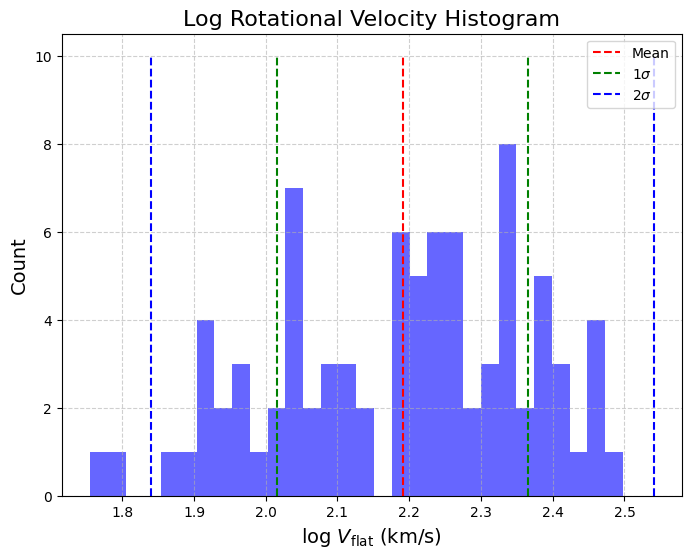

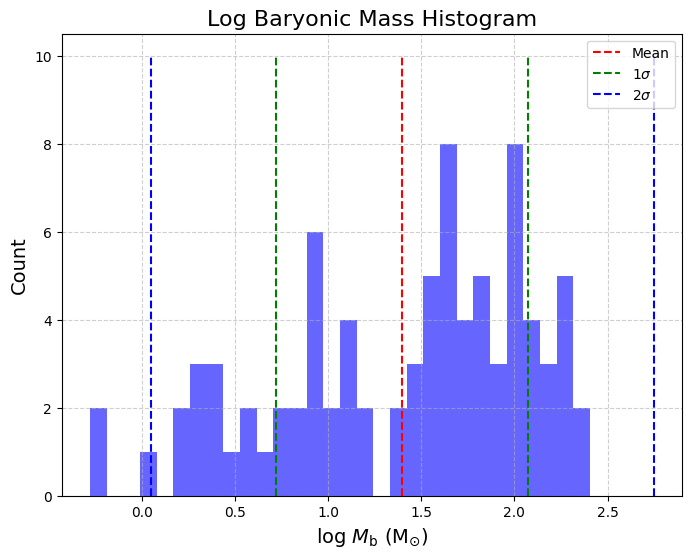

In [ ]:
# check data for outliers
# make histograms to see how data is distributed and make cuts using mean, std information from above
fig, ax = plt.subplots(figsize=(8,6))
ax.grid(True, linestyle="--", alpha=0.6)
ax.hist(df["logV"], bins=30, color = "b", alpha=0.6)
ax.vlines(logV_mean, 0, 10, linestyles="--", colors="r", label="Mean")
ax.vlines(logV_mean + logV_std, 0, 10, linestyles="--", colors="g", label="1$\sigma$")
ax.vlines(logV_mean - logV_std, 0, 10, linestyles="--", colors="g")
ax.vlines(logV_mean + (2*logV_std), 0, 10, linestyles="--", colors="b", label="2$\sigma$")
ax.vlines(logV_mean - (2*logV_std), 0, 10, linestyles="--", colors="b")
ax.set_xlabel(r"log $V_{\text{flat}}$ (km/s)", fontsize=14)
ax.set_ylabel(r"Count", fontsize=14)
ax.set_title("Log Rotational Velocity Histogram", fontsize=16)
ax.legend()
plt.show()

fig,ax = plt.subplots(figsize=(8,6))
ax.grid(True, linestyle="--", alpha=0.6)
ax.hist(df["log_M_b"], bins= 30, color = "b", alpha=0.6)
ax.vlines(log_M_b_mean, 0, 10, linestyles="--", colors="r", label="Mean")
ax.vlines(log_M_b_mean + log_M_b_std, 0, 10, linestyles="--", colors="g", label="1$\sigma$")
ax.vlines(log_M_b_mean - log_M_b_std, 0, 10, linestyles="--", colors="g")
ax.vlines(log_M_b_mean + (2*log_M_b_std), 0, 10, linestyles="--", colors="b", label="2$\sigma$")
ax.vlines(log_M_b_mean - (2*log_M_b_std), 0, 10, linestyles="--", colors="b")
ax.set_xlabel(r"log $M_{\text{b}}$ (M$_{\odot}$)", fontsize=14)
ax.set_ylabel(r"Count", fontsize=14)
ax.set_title("Log Baryonic Mass Histogram", fontsize=16)
ax.legend()
plt.show()

After removing the irregular galaxies and $V_{\text{flat}} = 0$ data, we see that most of the data roughly follows a normal distribution and is within or just outside the $2\sigma$ line for our dataset. While there are a few outliers in both of the datasets, none of them are large enough to be very concerning for our later linear regression (they should all fall within the $3\sigma$ interval). It does not look like we will need to make any more cuts to the data since it is fairly well behaved. We can now move on to the analysis.

# 4. Exploratory Data Analysis

Now that we have imported and formatted the data for use in this notebook, we should start by exploring the data and creating some plots. First off, we'll create a simple scatter plot, using our data to plot the log of the baryonic mass ($\text{log} \space M_{\text{b}}$) against the log of the rotation velocity ($\text{log} \space V_{\text{flat}}$).

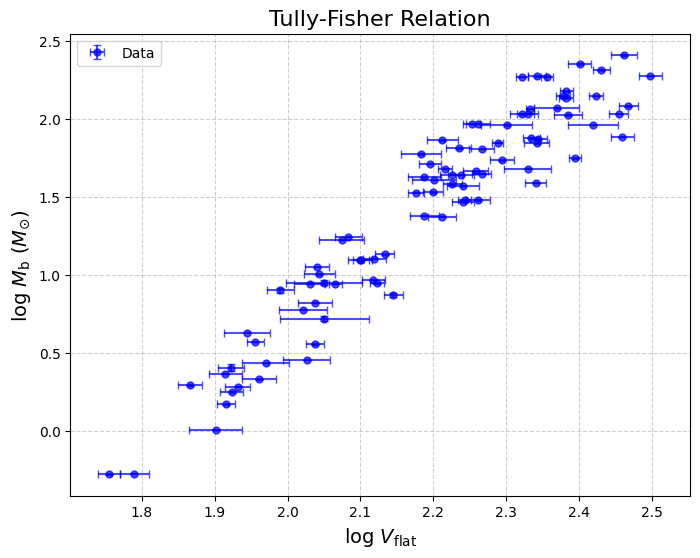

In [ ]:
# Create the plot
plt.figure(figsize=(8,6))
plt.errorbar(df["logV"], df["log_M_b"],
             xerr=df["e_logV"], yerr=df["log_e_M_b"],
             fmt="o", markersize=5, capsize=3, alpha=0.7, color="b", label="Data")
# Labels and title
plt.xlabel(r"log $V_{\text{flat}}$", fontsize=14)
plt.ylabel(r"log $M_{\text{b}}$ ($M_{\odot}$)", fontsize=14)
plt.title("Tully-Fisher Relation", fontsize=16)

# Grid and legend
plt.grid(True, linestyle="--", alpha=0.6)
plt.legend()
plt.show()

We see from the plot that there is a clear linear relationship between the log of the baryonic mass of a galaxy and the logarithm of its rotation velocity. This correlation aligns with the Tully-Fisher relation. To investigate this relationship further, we can use the data we have for the morphological type of the galaxies to plot each type of galaxy with a different marker. This will help us examine the possibility of any potentially significant relationship between a galaxy's morphologoical type and the Tully-Fisher relation for that galaxy.

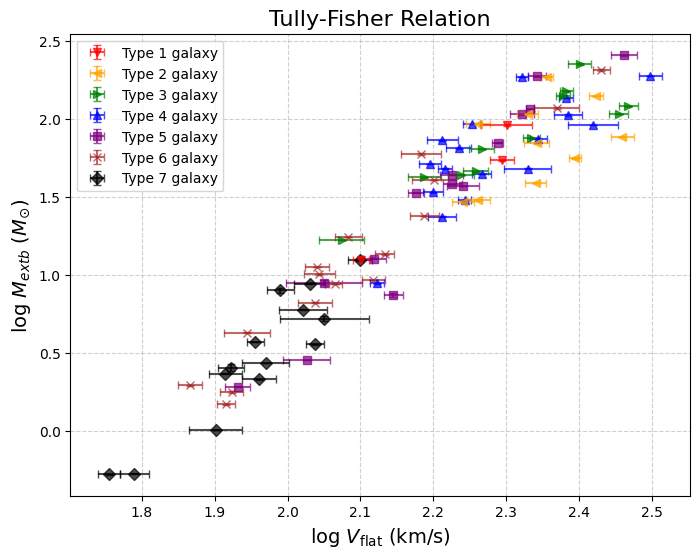

In [ ]:
# Define markers for different galaxy types
type_dict = {"1": "v", "2": "<", "3": ">", "4": "^", "5": "s", "6": "x", "7": "D"}

# Define distinct colors for different galaxy types
color_dict = {
    "1": "red", "2": "orange", "3": "green", "4": "blue",
    "5": "purple", "6": "brown", "7": "black"
}

# Create a set to keep track of labeled galaxy types
labeled_types = set()

# Initialize the figure and axis
fig, ax = plt.subplots(figsize=(8, 6))

# Loop through the data to plot points
for index, row in df.iterrows():
    galaxy_type = str(row["T"])

    label = f"Type {galaxy_type} galaxy" if galaxy_type not in labeled_types else None

    ax.errorbar(
        row["logV"], row["log_M_b"],
        xerr=row["e_logV"], yerr=row["log_e_M_b"],
        fmt=type_dict.get(galaxy_type, "o"),  # Default marker if type is missing
        markersize=6, capsize=3, alpha=0.7,
        color=color_dict.get(galaxy_type, "black"),  # Default to black if type is missing
        label=label
    )

    labeled_types.add(galaxy_type)

# Set axis labels and title
ax.set_xlabel(r"log $V_{\text{flat}}$ (km/s)", fontsize=14)
ax.set_ylabel("log $M_{\text{b}}$ ($M_{\\odot}$)", fontsize=14)
ax.set_title("Tully-Fisher Relation", fontsize=16)
ax.grid(True, linestyle="--", alpha=0.6)

# Automatically sort the legend by galaxy type
handles, labels = ax.get_legend_handles_labels()
sorted_legend = sorted(zip(labels, handles))  # Sort labels & handles together
sorted_labels, sorted_handles = zip(*sorted_legend)

ax.legend(sorted_handles, sorted_labels)
plt.show()

The above plot is the same as our previous plot except now the markers have been changed to indicate the type of galaxy that that point represents. We see that there are a few types of galaxies that tend to cluster in one area of the plot. For example, the late spiral galaxies (type 7) tend to cluster around the low baryonic mass, low rotational velocity part of the diagram. The majority of the early type through intermediate type galaxies (types 1, 2, 3, and 4) are in the high rotational velocity, high baryonic mass region of the plot. However, type 5 and type 6 galaxies, which are late-type galaxies, are distributed along the linear relationship unlike the other groups of spiral galaxies.

The distribution of galaxies described above could be caused by a number of factors. We know that late-type spiral galaxies tend to have less star formation due to interactions with other galaxies, which would explain the drop in baryonic mass. These gravitational interactions with other galaxies could also help to explain the drop in average rotational velocity because as the galaxy interacts and merges with others over time, the spread of star velocities increases. Many of the stars will be moving at lower speeds due to gravitational interactions which means that the average of the rotational velocity from all stars will be lower than when it first formed [1].

We see that there appears to be two different groupings of galaxies in the above plot. Looking at the types of galaxies that make up these groupings, we notice that the lower left grouping is made entirely of late type galaxies (types Sc, Scd, Sd) while the upper right grouping is made mostly of younger galaxies (types Sa, Sab, Sb, Sbc) with a few type Sc and Scd galaxies mixed in. Instead of separating and making a different marker for each galaxy type, let's group similar types and split all of the galaxies into two groups, either early-type or late-type galaxies.


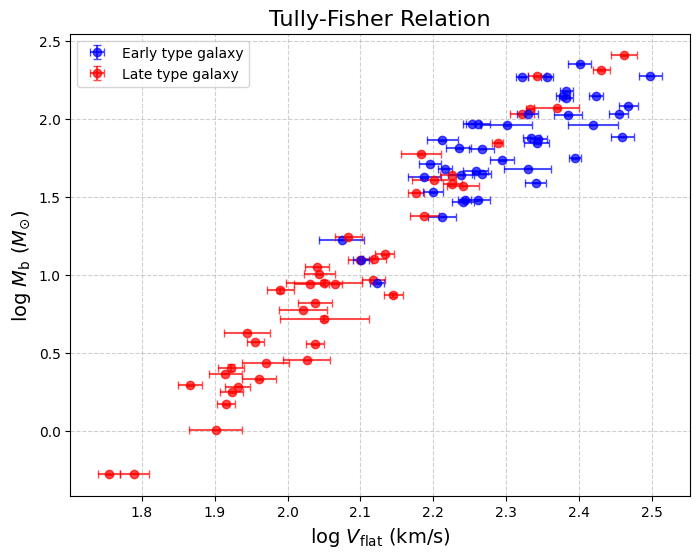

In [ ]:
import matplotlib.pyplot as plt

early_type_list = ["1", "2", "3", "4"]
late_type_list = ["5", "6", "7"]
row_list = []
fig, ax = plt.subplots(figsize=(8, 6))

early_label_added = False
late_label_added = False

for index, row in df.iterrows():
    if str(row["T"]) in early_type_list:
        ax.errorbar(row["logV"], row["log_M_b"], xerr=row["e_logV"], yerr=row["log_e_M_b"], fmt="o",
                    markersize=6, capsize=3, alpha=0.7, color="b",
                    label="Early type galaxy" if not early_label_added else "")
        early_label_added = True
    elif str(row["T"]) in late_type_list:
        ax.errorbar(row["logV"], row["log_M_b"], xerr=row["e_logV"], yerr=row["log_e_M_b"], fmt="o",
                    markersize=6, capsize=3, alpha=0.7, color="r",
                    label="Late type galaxy" if not late_label_added else "")
        late_label_added = True

ax.set_xlabel(r"log $V_{\text{flat}}$ (km/s)", fontsize=14)
ax.set_ylabel(r"log $M_{\text{b}}$ ($M_{\odot}$)", fontsize=14)
ax.set_title("Tully-Fisher Relation", fontsize=16)
ax.grid(True, linestyle="--", alpha=0.6)
ax.legend()
fig.show()

This new plot, splitting the galaxies into either early-type or late-type, better shows the distinction between our two groups in the Tully-Fisher relation. It is much clearer for us to see that early-type galaxies tend to have greater rotational velocity and baryonic mass, whereas late-type galaxies appear to have lower baryonic mass and rotational velocities.

# 5. Methodology: Bayesian Linear Regression

This analysis uses Bayesian Linear Regression: a method that uses the principles of Bayesian statistics to generate estimates (and uncertainties in those estimates) for the parameters in a linear regression problem. Typically, this approach also allows us to consider the confidence we have in the prior beliefs of what $a$ and $b$ should be. This approach also has the advantage of being completely analytically solvable [8].

### 5.1 Heteroscedastic Deming Regression

The specific variant of Bayesian Linear Regression that we will use in this analysis is called Heteroscedastic Deming Regression. This approach is important because it allows us to consider the heteroscedastic errors in our $v$ values as well as the heteroscedastic errors in our $M$ values simultaneously to find the parameters of best fit [9]. To obtain the uncertainties in these parameters, we will need to use a bootstrapping approach. Through this, we can obtain the posterior distribution

$$
p(b|M,\sigma_M,L,\sigma_L)
$$

which is the probability of obtaining parameter $b$ given the $M$ and $L$ data points with their uncertainties for each spiral galaxy. Notice how $a$ (the intercept) is gone from this formula. This is because Deming regression requires (for simplicity) that the data be centered (such that the mean of the distribution occurs at $\rm{(x, y) = (0, 0)}$ [9].

### 5.2 Grid Search

In order to solve for $b$, we will use a grid search to find the $b$ value that satisfies the following function [9]:

$$
F(b) = \sum_{i=1}^{N} \frac{ (σ_{M,i}^2v_{obs,i} + bσ_{v,i}^2M_{obs,i})}{(σ_{M,i}^2 + b^2σ_{v,i}^2)}  (M_{obs,i} – bv_{obs,i}) = 0
$$

For obvious reasons this grid search method is much easier than solving the above equation analytically (if even at all possible). Other numerical methods are also less efficient.

# 6. Results

We will use the Bayesian linear regression methods of Ordinary Least Squares and a grid search combined with Deming regression to fit a slope to our data's relationship between rotational velocity and baryonic mass. Everything will be fitted in log scale which will allow us to analyze the exponential relationship as described by the Tully-Fisher relation. We will start by fitting a line to the complete dataset to see if we can roughly reproduce the relation using our data.

OLS regression slope (ignoring error in x):
  Slope: 3.723

Deming regression slope (heteroscedastic, grid search):
  Slope: 4.042


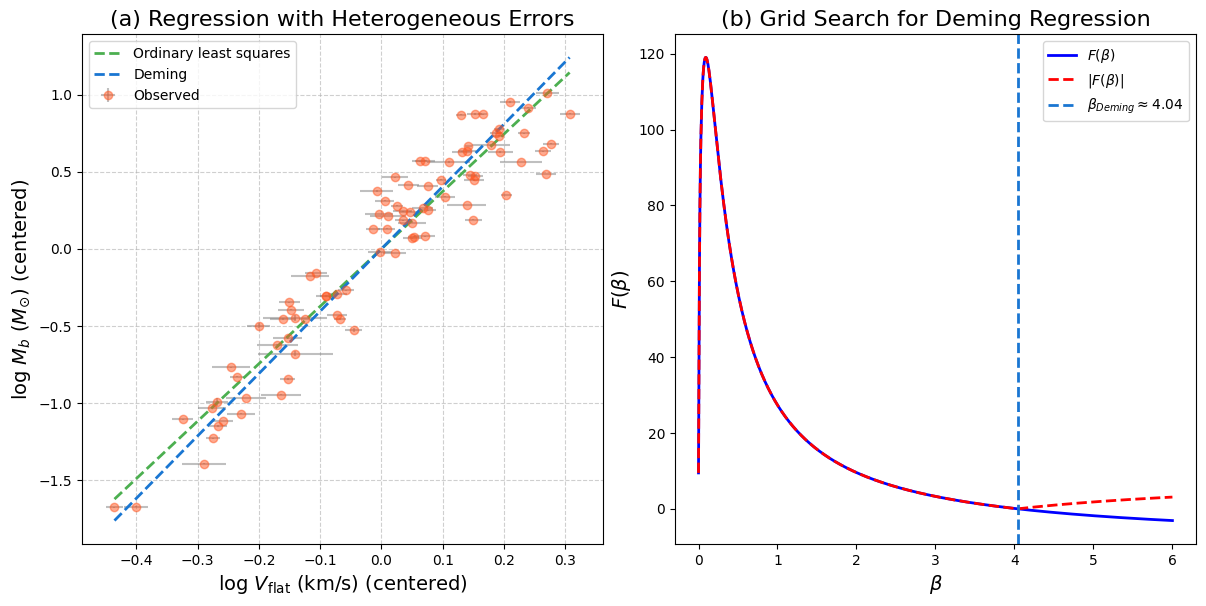

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Center the observed data
x_obs = df["logV"] - np.mean(df["logV"])
y_obs = df["log_M_b"] - np.mean(df["log_M_b"])
sigma_x = df["e_logV"]
sigma_y = df["log_e_M_b"]

# ----- Fit an OLS regression (ignoring error in x) -----
# OLS slope = Cov(x_obs, y_obs) / Var(x_obs)
beta_ols = np.cov(x_obs, y_obs)[0, 1] / np.var(x_obs)
print("OLS regression slope (ignoring error in x):")
print(f"  Slope: {beta_ols:.3f}")

# ----- Define the heteroscedastic Deming regression function -----
# For each data point, we have measurement errors sigma_x[i] and sigma_y[i].
# The function F(beta) whose zero we seek is:
#
#   F(β) = Σ [ (σ_y,i²*x_obs,i + β*σ_x,i²*y_obs,i) / (σ_y,i² + β²*σ_x,i²) ] * (y_obs,i – β*x_obs,i)
#
# When F(β) = 0, the Deming regression slope is obtained.
def F_beta(beta, x_obs, y_obs, sigma_x, sigma_y):
    total = 0.0
    for i in range(len(x_obs)):
        numerator = sigma_y.iloc[i]**2 * x_obs.iloc[i] + beta * sigma_x.iloc[i]**2 * y_obs.iloc[i]
        denominator = sigma_y.iloc[i]**2 + beta**2 * sigma_x.iloc[i]**2
        total += (numerator / denominator) * (y_obs.iloc[i] - beta * x_obs.iloc[i])
    return total

# ----- Solve for β via grid search -----
# In one dimension a grid search is simple and effective.
# Define a grid of candidate β values. (The range should bracket the true slope.)
beta_grid = np.linspace(0.0, 6.0, 1000)

# Evaluate F(β) over the grid
F_vals = np.array([F_beta(beta, x_obs, y_obs, sigma_x, sigma_y) for beta in beta_grid])
abs_F_vals = np.abs(F_vals)

# Find the β that minimizes |F(β)| (ideally zero)
min_index = np.argmin(abs_F_vals)
beta_deming = beta_grid[min_index]
print("\nDeming regression slope (heteroscedastic, grid search):")
print(f"  Slope: {beta_deming:.3f}")

# ----- Plot the results for visualization -----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Panel (a): Show observed data with error bars and regression fits
ax1.errorbar(x_obs, y_obs, xerr=sigma_x, yerr=sigma_y, fmt='o',
             color='#FF5722', ecolor='gray', alpha=0.5, label='Observed')
x_line = np.linspace(min(x_obs), max(x_obs), 100)
#ax1.plot(x_line, true_slope * x_line, 'k-', linewidth=2, label='True relation: $y=3x$')
ax1.plot(x_line, beta_ols * x_line, '--', color='#4CAF50', linewidth=2,
         label='Ordinary least squares')
ax1.plot(x_line, beta_deming * x_line, '--', color='#1976D2', linewidth=2,
         label=f'Deming')
ax1.set_title('(a) Regression with Heterogeneous Errors', fontsize=16)
ax1.set_xlabel(r"log $V_{\text{flat}}$ (km/s) (centered)", fontsize=14)
ax1.set_ylabel(r"log $M_b$ ($M_{\odot}$) (centered)", fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, linestyle="--", alpha=0.6)

# Panel (b): Plot F(β) and |F(β)| versus β to show the grid search
ax2.plot(beta_grid, F_vals, 'b-', linewidth=2, label='$F(\\beta)$')
ax2.plot(beta_grid, abs_F_vals, 'r--', linewidth=2, label='$|F(\\beta)|$')
ax2.axvline(beta_deming, color='#1976D2', linestyle='--', linewidth=2,
            label=f'$\\beta_{{Deming}}\\approx {beta_deming:.2f}$')
ax2.set_xlabel('$\\beta$', fontsize=14)
ax2.set_ylabel('$F(\\beta)$', fontsize=14)
ax2.set_title('(b) Grid Search for Deming Regression', fontsize=16)
ax2.legend(loc='upper right')

plt.tight_layout(pad=0.5)
plt.show()

In the above plot we compare the Deming regression fit from a grid search of the data to the least squares fit. Comparing the two lines, we see the Deming regression follows the trend of the data and reproduces the expected slope much better than the least squares fit. As described in the introduction discussion, the known relationship for the Tully-Fisher relation is $L \propto v^4$ which is reproduced in our results above. We know that baryonic mass can be converted into luminosity through a porportionality factor so our slope of roughly 4 in the relationship between rotational velocity and baryonic mass is exactly what we would expect to see based on previous research.

As mentioned in the preliminary analysis, there appears to be a split between early (types 1, 2, 3, and 4) and late-type (types 5, 6, and 7) galaxies in the plot. Let's consider how our fit changes if we fit these two types of galaxies seperately. We will start by fitting the early galaxies with a Deming and least squares regression and compare these to a fit to the late-type galaxies. We may find that there is a slighlty different relationship to rotational velocity between these two types of galaxies.

OLS regression slope (ignoring error in x):
  Slope: 2.581

Deming regression slope (heteroscedastic, grid search):
  Slope: 4.054


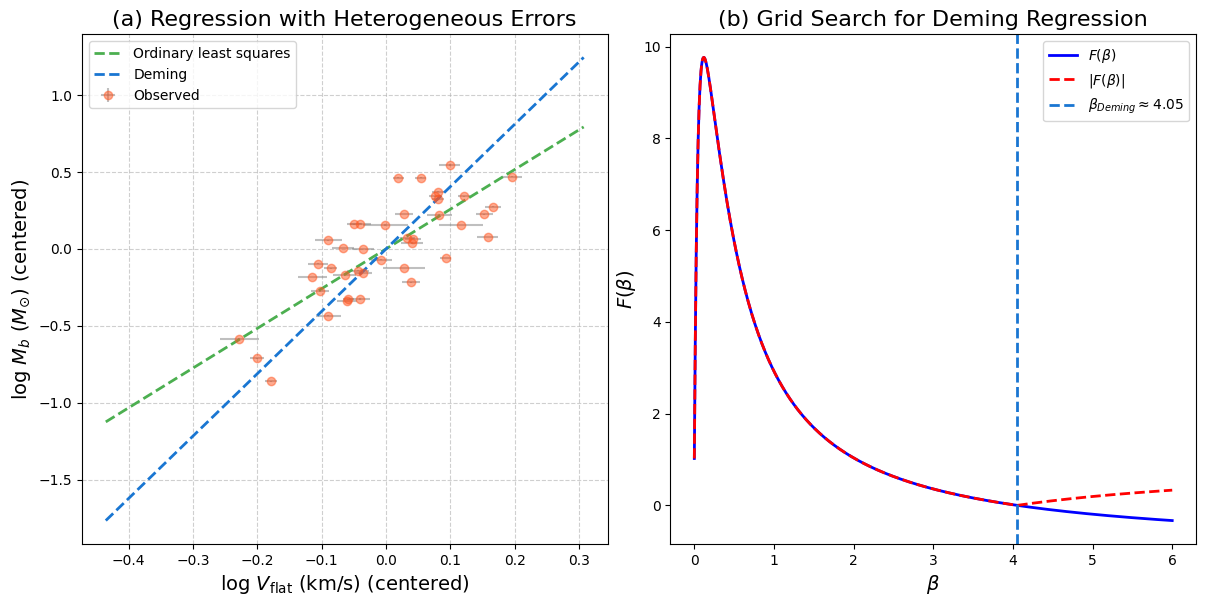

In [ ]:
# sort out all older galaxies
condition = (df["T"] != 5) & (df["T"] != 6) & (df["T"] != 7)
df_young = df[condition]

# Center the observed data
x_obs_young = df_young["logV"] - np.mean(df_young["logV"])
y_obs_young = df_young["log_M_b"] - np.mean(df_young["log_M_b"])
sigma_x_young = df_young["e_logV"]
sigma_y_young = df_young["log_e_M_b"]

# ----- Fit an OLS regression (ignoring error in x) -----
# OLS slope = Cov(x_obs, y_obs) / Var(x_obs)
beta_ols = np.cov(x_obs_young, y_obs_young)[0, 1] / np.var(x_obs_young)
print("OLS regression slope (ignoring error in x):")
print(f"  Slope: {beta_ols:.3f}")

# ----- Define the heteroscedastic Deming regression function -----
# For each data point, we have measurement errors sigma_x[i] and sigma_y[i].
# The function F(beta) whose zero we seek is:
#
#   F(β) = Σ [ (σ_y,i²*x_obs,i + β*σ_x,i²*y_obs,i) / (σ_y,i² + β²*σ_x,i²) ] * (y_obs,i – β*x_obs,i)
#
# When F(β) = 0, the Deming regression slope is obtained.
def F_beta(beta, x_obs, y_obs, sigma_x, sigma_y):
    total = 0.0
    for i in range(len(x_obs)):
        numerator = sigma_y.iloc[i]**2 * x_obs.iloc[i] + beta * sigma_x.iloc[i]**2 * y_obs.iloc[i]
        denominator = sigma_y.iloc[i]**2 + beta**2 * sigma_x.iloc[i]**2
        total += (numerator / denominator) * (y_obs.iloc[i] - beta * x_obs.iloc[i])
    return total

# ----- Solve for β via grid search -----
# In one dimension a grid search is simple and effective.
# Define a grid of candidate β values. (The range should bracket the true slope.)
beta_grid = np.linspace(0.0, 6.0, 1000)

# Evaluate F(β) over the grid
F_vals = np.array([F_beta(beta, x_obs_young, y_obs_young, sigma_x_young, sigma_y_young) for beta in beta_grid])
abs_F_vals = np.abs(F_vals)

# Find the β that minimizes |F(β)| (ideally zero)
min_index = np.argmin(abs_F_vals)
beta_deming_young = beta_grid[min_index]
print("\nDeming regression slope (heteroscedastic, grid search):")
print(f"  Slope: {beta_deming_young:.3f}")

# ----- Plot the results for visualization -----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Panel (a): Show observed data with error bars and regression fits
ax1.errorbar(x_obs_young, y_obs_young, xerr=sigma_x_young, yerr=sigma_y_young, fmt='o',
             color='#FF5722', ecolor='gray', alpha=0.5, label='Observed')
x_line = np.linspace(min(x_obs), max(x_obs), 100)
#ax1.plot(x_line, true_slope * x_line, 'k-', linewidth=2, label='True relation: $y=3x$')
ax1.plot(x_line, beta_ols * x_line, '--', color='#4CAF50', linewidth=2,
         label='Ordinary least squares')
ax1.plot(x_line, beta_deming_young * x_line, '--', color='#1976D2', linewidth=2,
         label=f'Deming')
ax1.set_title('(a) Regression with Heterogeneous Errors', fontsize=16)
ax1.set_xlabel(r"log $V_{\text{flat}}$ (km/s) (centered)", fontsize=14)
ax1.set_ylabel(r"log $M_b$ ($M_{\odot}$) (centered)", fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, linestyle="--", alpha=0.6)

# Panel (b): Plot F(β) and |F(β)| versus β to show the grid search
ax2.plot(beta_grid, F_vals, 'b-', linewidth=2, label='$F(\\beta)$')
ax2.plot(beta_grid, abs_F_vals, 'r--', linewidth=2, label='$|F(\\beta)|$')
ax2.axvline(beta_deming_young, color='#1976D2', linestyle='--', linewidth=2,
            label=f'$\\beta_{{Deming}}\\approx {beta_deming_young:.2f}$')
ax2.set_xlabel('$\\beta$', fontsize=14)
ax2.set_ylabel('$F(\\beta)$', fontsize=14)
ax2.set_title('(b) Grid Search for Deming Regression', fontsize=16)
ax2.legend(loc='upper right')

plt.tight_layout(pad=0.5)
plt.show()

After completing a least squares and Deming regression fit to the early-type galaxies (types 1, 2, 3, and 4), it is clear that the set of data is too tighlty clustered to get a good fit. These younger galaxies are very closely distributed in a small region of parameter space but still have a fairly wide spread, this leaves room for a lot of interpretation in the slope. For this reason, the least squares and Deming regression disagree by a fairly large margin.

However, as we mentioned at the begining of the analysis, the grid search of the Deming regression will give a truer fit because it searches for the best fit based on the data and errors. This is echoed in it's calculated slope compared to the least squares slope. The Deming regression with grid search returned a slope of around 4 while the least squares fit returned a slope close of about 2.6. As discussed above, we know that a slope of 4 is the accepted value, for this reason, we will accept the Deming regression fit as the best estimate of the relation between rotational velocity and baryonic mass for the young galaxies.

Next, we will conduct the same fit for the late-type galaxies. We expect these to closely reproduce the slope from our initial fit with all galaxies since they are distributed far more across the parameter space and intersect the distribution of early-type galaxies.

OLS regression slope (ignoring error in x):
  Slope: 4.181

Deming regression slope (heteroscedastic, grid search):
  Slope: 4.318


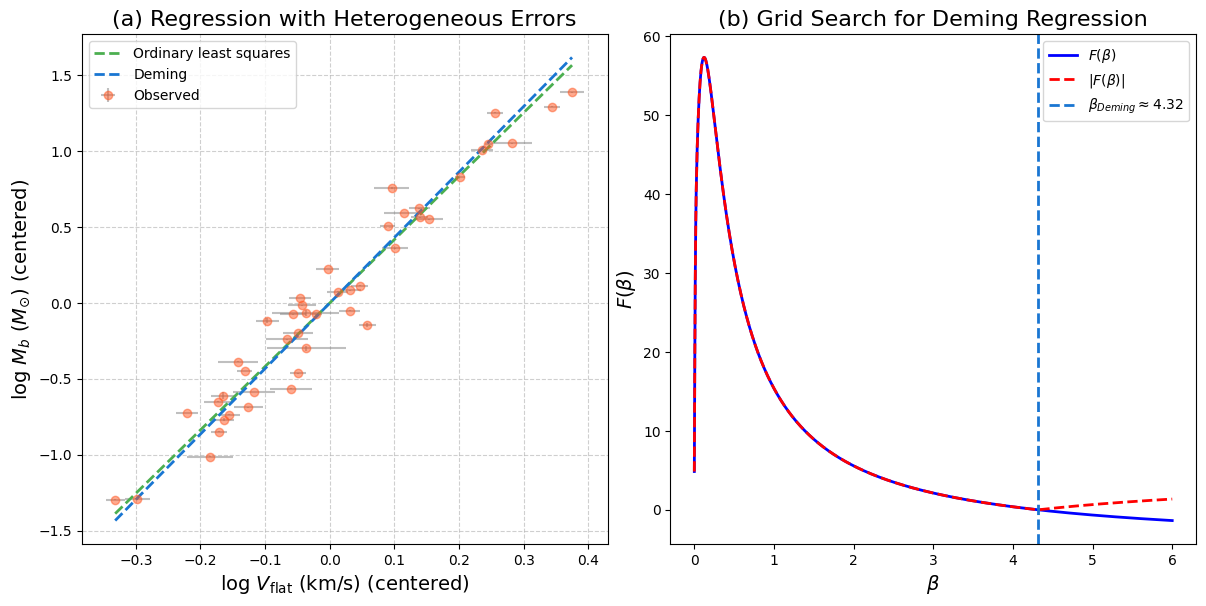

In [ ]:
# sort out all younger galaxies
condition = (df["T"] != 1) & (df["T"] != 2) & (df["T"] != 3) & (df["T"] != 4)
df_old = df[condition]

# Center the observed data
x_obs_old = df_old["logV"] - np.mean(df_old["logV"])
y_obs_old = df_old["log_M_b"] - np.mean(df_old["log_M_b"])
sigma_x_old = df_old["e_logV"]
sigma_y_old = df_old["log_e_M_b"]

# ----- Fit an OLS regression (ignoring error in x) -----
# OLS slope = Cov(x_obs, y_obs) / Var(x_obs)
beta_ols = np.cov(x_obs_old, y_obs_old)[0, 1] / np.var(x_obs_old)
print("OLS regression slope (ignoring error in x):")
print(f"  Slope: {beta_ols:.3f}")

# ----- Define the heteroscedastic Deming regression function -----
# For each data point, we have measurement errors sigma_x[i] and sigma_y[i].
# The function F(beta) whose zero we seek is:
#
#   F(β) = Σ [ (σ_y,i²*x_obs,i + β*σ_x,i²*y_obs,i) / (σ_y,i² + β²*σ_x,i²) ] * (y_obs,i – β*x_obs,i)
#
# When F(β) = 0, the Deming regression slope is obtained.
def F_beta(beta, x_obs, y_obs, sigma_x, sigma_y):
    total = 0.0
    for i in range(len(x_obs)):
        numerator = sigma_y.iloc[i]**2 * x_obs.iloc[i] + beta * sigma_x.iloc[i]**2 * y_obs.iloc[i]
        denominator = sigma_y.iloc[i]**2 + beta**2 * sigma_x.iloc[i]**2
        total += (numerator / denominator) * (y_obs.iloc[i] - beta * x_obs.iloc[i])
    return total

# ----- Solve for β via grid search -----
# In one dimension a grid search is simple and effective.
# Define a grid of candidate β values. (The range should bracket the true slope.)
beta_grid = np.linspace(0.0, 6.0, 1000)

# Evaluate F(β) over the grid
F_vals = np.array([F_beta(beta, x_obs_old, y_obs_old, sigma_x_old, sigma_y_old) for beta in beta_grid])
abs_F_vals = np.abs(F_vals)

# Find the β that minimizes |F(β)| (ideally zero)
min_index = np.argmin(abs_F_vals)
beta_deming_old = beta_grid[min_index]
print("\nDeming regression slope (heteroscedastic, grid search):")
print(f"  Slope: {beta_deming_old:.3f}")

# ----- Plot the results for visualization -----
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

# Panel (a): Show observed data with error bars and regression fits
ax1.errorbar(x_obs_old, y_obs_old, xerr=sigma_x_old, yerr=sigma_y_old, fmt='o',
             color='#FF5722', ecolor='gray', alpha=0.5, label='Observed')
x_line = np.linspace(min(x_obs_old), max(x_obs_old), 100)
#ax1.plot(x_line, true_slope * x_line, 'k-', linewidth=2, label='True relation: $y=3x$')
ax1.plot(x_line, beta_ols * x_line, '--', color='#4CAF50', linewidth=2,
         label='Ordinary least squares')
ax1.plot(x_line, beta_deming_old * x_line, '--', color='#1976D2', linewidth=2,
         label=f'Deming')
ax1.set_title('(a) Regression with Heterogeneous Errors', fontsize=16)
ax1.set_xlabel(r"log $V_{\text{flat}}$ (km/s) (centered)", fontsize=14)
ax1.set_ylabel(r"log $M_b$ ($M_{\odot}$) (centered)", fontsize=14)
ax1.legend(loc='upper left')
ax1.grid(True, linestyle="--", alpha=0.6)

# Panel (b): Plot F(β) and |F(β)| versus β to show the grid search
ax2.plot(beta_grid, F_vals, 'b-', linewidth=2, label='$F(\\beta)$')
ax2.plot(beta_grid, abs_F_vals, 'r--', linewidth=2, label='$|F(\\beta)|$')
ax2.axvline(beta_deming_old, color='#1976D2', linestyle='--', linewidth=2,
            label=f'$\\beta_{{Deming}}\\approx {beta_deming_old:.2f}$')
ax2.set_xlabel('$\\beta$', fontsize=14)
ax2.set_ylabel('$F(\\beta)$', fontsize=14)
ax2.set_title('(b) Grid Search for Deming Regression', fontsize=16)
ax2.legend(loc='upper right')

plt.tight_layout(pad=0.5)
plt.show()

As expected, the fit of these late-type galaxies is much tighter than the fit for the early-types. However, the slopes that the fits returned are much different than what was expected. We expected that the late-type galaxies would follow a slope that is again very close to 4, however, we see that the least squares and Deming regression both returned fits that have slopes slightly larger than 4—about 4.2 for least squares and 4.3 for Deming.

We know that the grid search with Deming regression generally reproduces truer fits so this could indicate a significant difference in the relationship between rotational velocity and baryonic mass for late-type galaxies as compared to early-type galaxies. To analize our current fits, we will conduct an error analysis which could reveal that the error in our fits of the early and late type galaxies overlap. This will help us determine whether or not futher analysis is needed to investigate the deviation in slopes; we would leave this for future work if it is necessary.

# 7. Error Analysis

We can start our error analysis by looking at the errors in the Deming regression fit of the complete data set. We will analyze the residuals of the fit, the RMSE, and the 95% confidence interval. We will use a bootstrap analysis to check the validity of the slopes.

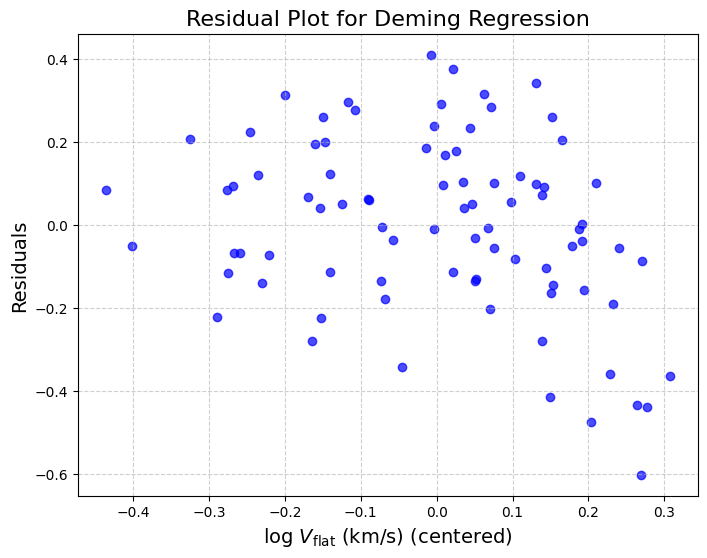

95% Confidence Interval for slope: [3.89129129 4.35885886]


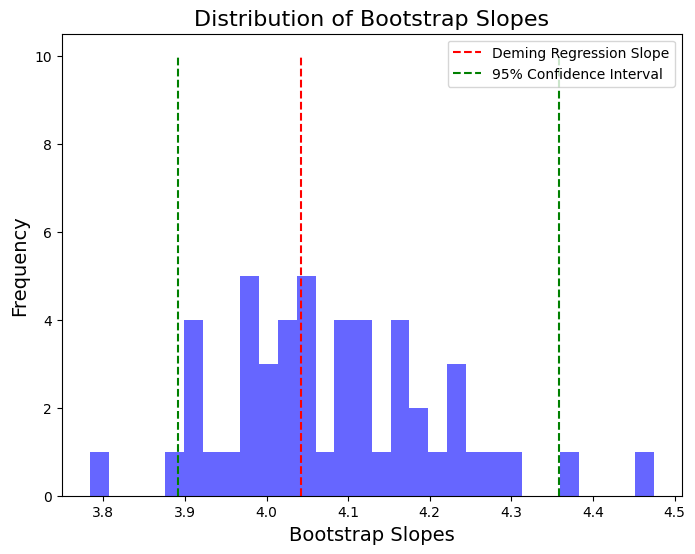

R-squared: 0.901
RMSE: 0.211


In [ ]:
# prompt: error analysis for deming regression using data

# Assuming 'df' is your DataFrame and the necessary libraries are imported

# Analyze residuals
residuals = y_obs - beta_deming * x_obs
plt.figure(figsize=(8, 6))
plt.scatter(x_obs, residuals, alpha=0.7, c="b")
plt.xlabel(r"log $V_{\text{flat}}$ (km/s) (centered)", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.title("Residual Plot for Deming Regression", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Investigate outliers
# Identify data points with large residuals or leverage
# Analyze their properties (galaxy type, other features)
# Consider removing outliers if justified

# Bootstrapping for uncertainty estimation
n_bootstrap = 50
bootstrap_slopes = []

for _ in range(n_bootstrap):
    # Resample data with replacement
    indices = np.random.choice(len(x_obs), size=len(x_obs), replace=True)
    x_boot = x_obs.iloc[indices]
    y_boot = y_obs.iloc[indices]
    sigma_x_boot = sigma_x.iloc[indices]
    sigma_y_boot = sigma_y.iloc[indices]

    # Perform Deming regression on the bootstrap sample
    F_vals_boot = np.array([F_beta(beta, x_boot, y_boot, sigma_x_boot, sigma_y_boot) for beta in beta_grid])
    abs_F_vals_boot = np.abs(F_vals_boot)
    min_index_boot = np.argmin(abs_F_vals_boot)
    beta_deming_boot = beta_grid[min_index_boot]
    bootstrap_slopes.append(beta_deming_boot)

# Calculate confidence intervals for the slope
confidence_interval = np.percentile(bootstrap_slopes, [2.5, 97.5])
print(f"95% Confidence Interval for slope: {confidence_interval}")

# Analyze the distribution of bootstrap slopes
plt.figure(figsize=(8, 6))
plt.hist(bootstrap_slopes, bins=30, color = "b", alpha=0.6)
plt.xlabel("Bootstrap Slopes", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.vlines(beta_deming, 0, 10, color="r", linestyle="--", label="Deming Regression Slope")
plt.vlines(confidence_interval, 0, 10, color="g", linestyle="--", label="95% Confidence Interval")
plt.legend()
plt.title("Distribution of Bootstrap Slopes", fontsize=16)
plt.show()

# Calculate key metrics (R-squared, RMSE, etc.)
from sklearn.metrics import r2_score, mean_squared_error
y_pred = beta_deming * x_obs

r2 = r2_score(y_obs, y_pred)
rmse = np.sqrt(mean_squared_error(y_obs, y_pred))

print(f"R-squared: {r2:.3f}")
print(f"RMSE: {rmse:.3f}")

Analyzing the residuals plot, we see that the galaxies with high rotational velocities have the greatest disagreement from the expected line. The galaxies that have 0 rotational velocity also have fairly high residuals. This might be expected because the rotational velocity will be hard to measure due to the uncertianty in measurments of large rotational velocity and zero rotational velocity when doing a spectral analysis.

Looking at the confidence intervals of the fit and how they compare to a bootstrapping analysis, we see that our fit appears to be reasonable. Many of the bootstrapping slopes fall well within the 95% confidence interval and the majority fall close to or a little above the slope that we got from our earlier analysis. In general, using the data that we are given with slightly different permutations, the bootstrapping returns a majority of slopes that are close to our original fit. This tells us that our Deming regression with grid search did a good job of finding the most probable/ best fitting slopes offered by the data.

Finally, analyzing the R-squared and RMSE metrics, we see that they both agree that the fit to the data is very good. An R-squared of 0.9 tells us that the rotational velocity is very strongly correlated with baryonic mass in the data. In other words, the change in the rotatioinal velocity across the dataset is almost entirely explained by the change in baryonic mass. The RMSE of about 0.2 tells us that the error in the fit of our data is reasonably small and so the model is fairly accurate. We may be able to improve the RMSE by doing a more complex grid search or getting more data but for the purposes of our analysis, this is fairly good.

To get a better idea of how these errors are different for different samples, we can analyze the errors in a similar way as above but instead looking at the young galaxy sample.

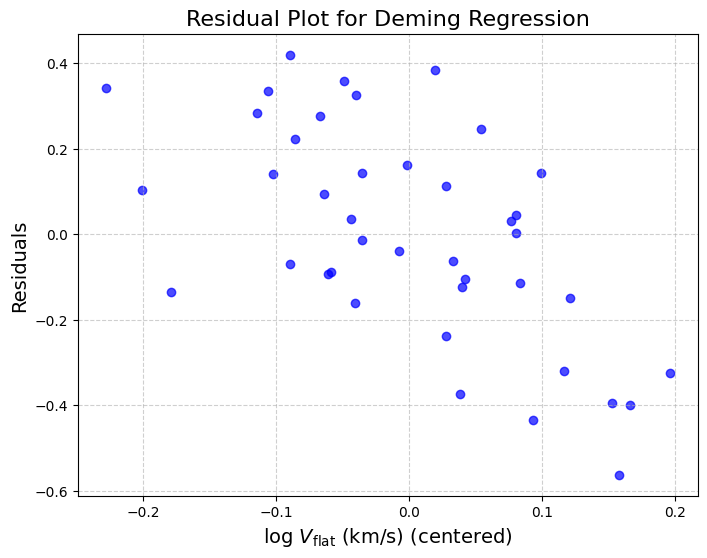

95% Confidence Interval for slope: [3.84594595 4.27222222]


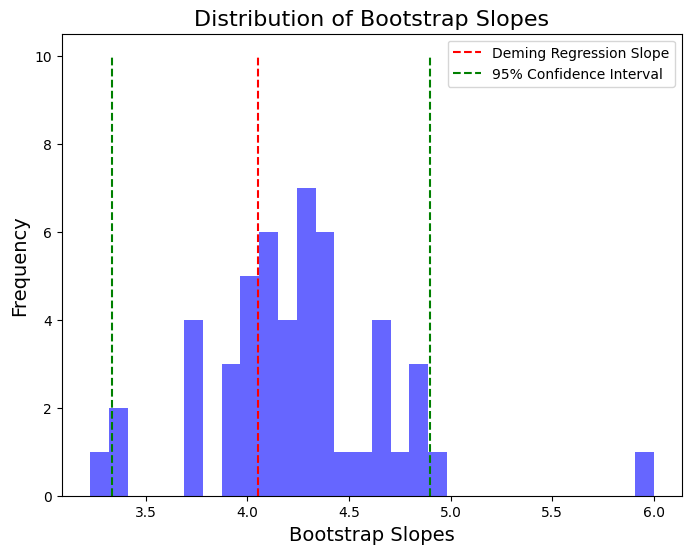

R-squared: 0.390
RMSE: 0.248


In [ ]:
# Analyze residuals
residuals_young = y_obs_young - beta_deming_young * x_obs_young
plt.figure(figsize=(8, 6))
plt.scatter(x_obs_young, residuals_young, alpha=0.7, c="b")
plt.xlabel(r"log $V_{\text{flat}}$ (km/s) (centered)", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.title("Residual Plot for Deming Regression", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Investigate outliers
# Identify data points with large residuals or leverage
# Analyze their properties (galaxy type, other features)
# Consider removing outliers if justified

# Bootstrapping for uncertainty estimation
n_bootstrap = 50
bootstrap_slopes = []

for _ in range(n_bootstrap):
    # Resample data with replacement
    indices = np.random.choice(len(x_obs_young), size=len(x_obs_young), replace=True)
    x_boot = x_obs_young.iloc[indices]
    y_boot = y_obs_young.iloc[indices]
    sigma_x_boot = sigma_x_young.iloc[indices]
    sigma_y_boot = sigma_y_young.iloc[indices]

    # Perform Deming regression on the bootstrap sample
    F_vals_boot = np.array([F_beta(beta, x_boot, y_boot, sigma_x_boot, sigma_y_boot) for beta in beta_grid])
    abs_F_vals_boot = np.abs(F_vals_boot)
    min_index_boot = np.argmin(abs_F_vals_boot)
    beta_deming_boot = beta_grid[min_index_boot]
    bootstrap_slopes.append(beta_deming_boot)

# Calculate confidence intervals for the slope
confidence_interval_young = np.percentile(bootstrap_slopes, [2.5, 97.5])
print(f"95% Confidence Interval for slope: {confidence_interval}")

# Analyze the distribution of bootstrap slopes
plt.figure(figsize=(8, 6))
plt.hist(bootstrap_slopes, bins=30, color = "b", alpha=0.6)
plt.xlabel("Bootstrap Slopes", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.vlines(beta_deming_young, 0, 10, color="r", linestyle="--", label="Deming Regression Slope")
plt.vlines(confidence_interval_young, 0, 10, color="g", linestyle="--", label="95% Confidence Interval")
plt.legend()
plt.title("Distribution of Bootstrap Slopes", fontsize=16)
plt.show()

# Calculate key metrics (R-squared, RMSE, etc.)
from sklearn.metrics import r2_score, mean_squared_error
y_pred_young = beta_deming_young * x_obs_young

r2_young = r2_score(y_obs_young, y_pred_young)
rmse_young = np.sqrt(mean_squared_error(y_obs_young, y_pred_young))

print(f"R-squared: {r2_young:.3f}")
print(f"RMSE: {rmse_young:.3f}")

As before, we can start by analyzing the residuals plot. We see that the galaxies with high rotational velocities have the greatest disagreement from the expected line. Again, this might be expected because the rotational velocity will be hard to measure both due to the uncertainty in measurments of large rotational velocity when doing a spectral analysis.

Next, looking at the confidence intervals of the fit and how they compare to a bootstrapping analysis, we see that our fit appears to be reasonable. Many of the bootstrapping slopes again fall well within the 95% confidence interval and the majority are very cloes to the slope that we got from our earlier analysis. This tells us that our Deming regression with grid search did a good job of finding the most probable/ best fitting slopes offered by the data.

Finally, analyzing the R-squared and RMSE metrics, we see that they both agree that the fit to the data is decent. An R-squared of 0.4 tells us that the rotational velocity is correlated with baryonic mass but not strongly. This is to be exptected because the early-type galaxies had a very large spread in their rotational velocities compared to their baryonic mass. The RMSE of about 0.25 tells us that the error in the fit of our data is reasonably small and so the model is fairly accurate.

Now, we can continue this analysis to the sample of older galaxies. We will conduct the same analysis as we did with the total sample and the young galaxy sample. Once we complete this, we can compare the errors and analyze how the sample size and type of galaxy effects the errors in the deming regression.

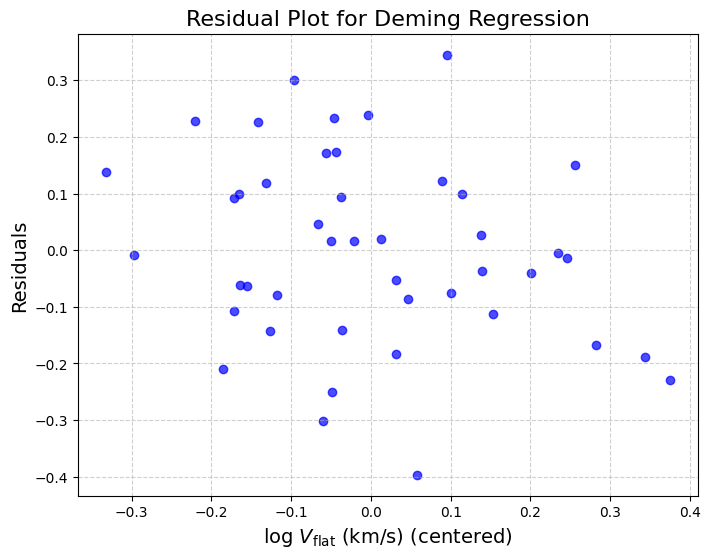

95% Confidence Interval for slope: [3.84594595 4.27222222]


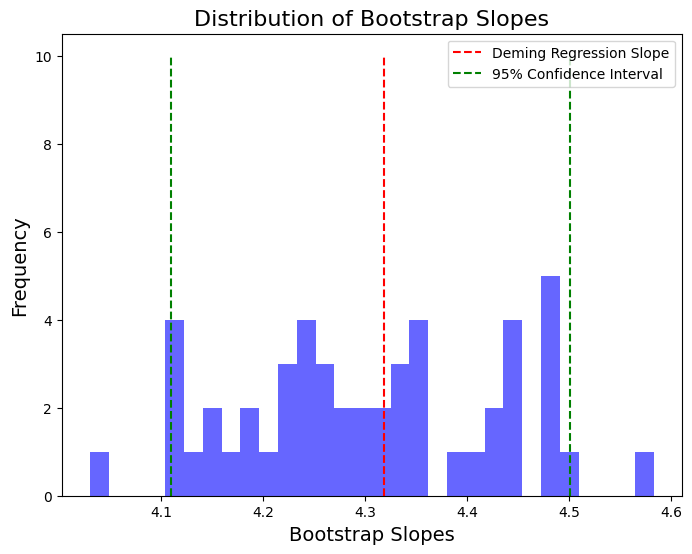

R-squared: 0.943
RMSE: 0.165


In [ ]:
# Analyze residuals
residuals_old = y_obs_old - beta_deming_old * x_obs_old
plt.figure(figsize=(8, 6))
plt.scatter(x_obs_old, residuals_old, alpha=0.7, c="b")
plt.xlabel(r"log $V_{\text{flat}}$ (km/s) (centered)", fontsize=14)
plt.ylabel("Residuals", fontsize=14)
plt.title("Residual Plot for Deming Regression", fontsize=16)
plt.grid(True, linestyle="--", alpha=0.6)
plt.show()

# Investigate outliers
# Identify data points with large residuals or leverage
# Analyze their properties (galaxy type, other features)
# Consider removing outliers if justified

# Bootstrapping for uncertainty estimation
n_bootstrap = 50
bootstrap_slopes = []

for _ in range(n_bootstrap):
    # Resample data with replacement
    indices = np.random.choice(len(x_obs_old), size=len(x_obs_old), replace=True)
    x_boot = x_obs_old.iloc[indices]
    y_boot = y_obs_old.iloc[indices]
    sigma_x_boot = sigma_x_old.iloc[indices]
    sigma_y_boot = sigma_y_old.iloc[indices]

    # Perform Deming regression on the bootstrap sample
    F_vals_boot = np.array([F_beta(beta, x_boot, y_boot, sigma_x_boot, sigma_y_boot) for beta in beta_grid])
    abs_F_vals_boot = np.abs(F_vals_boot)
    min_index_boot = np.argmin(abs_F_vals_boot)
    beta_deming_boot = beta_grid[min_index_boot]
    bootstrap_slopes.append(beta_deming_boot)

# Calculate confidence intervals for the slope
confidence_interval_old = np.percentile(bootstrap_slopes, [2.5, 97.5])
print(f"95% Confidence Interval for slope: {confidence_interval}")

# Analyze the distribution of bootstrap slopes
plt.figure(figsize=(8, 6))
plt.hist(bootstrap_slopes, bins=30, color = "b", alpha=0.6)
plt.xlabel("Bootstrap Slopes", fontsize=14)
plt.ylabel("Frequency", fontsize=14)
plt.vlines(beta_deming_old, 0, 10, color="r", linestyle="--", label="Deming Regression Slope")
plt.vlines(confidence_interval_old, 0, 10, color="g", linestyle="--", label="95% Confidence Interval")
plt.legend()
plt.title("Distribution of Bootstrap Slopes", fontsize=16)
plt.show()

# Calculate key metrics (R-squared, RMSE, etc.)
from sklearn.metrics import r2_score, mean_squared_error
y_pred_old = beta_deming_old * x_obs_old

r2_old = r2_score(y_obs_old, y_pred_old)
rmse_old = np.sqrt(mean_squared_error(y_obs_old, y_pred_old))

print(f"R-squared: {r2_old:.3f}")
print(f"RMSE: {rmse_old:.3f}")

Analyzing the residuals plot, we again see that the galaxies with high rotational velocities have the greatest disagreement from the expected line. As before, this might be expected because the rotational velocity will be hard to measure due to the uncertianty in measurments of large rotational velocity when doing a spectral analysis.

Looking at the confidence intervals of the fit and how they compare to a bootstrapping anlysis, we see that our fit appears to be reasonable. Many of the bootstrapping slopes fall well within the 95% confidence interval and the majority fall a little above or below the slope that we got from our earlier analysis. It looks like our Deming regression with grid search did a good job of finding the most probable/ best fitting slopes offered by the data.

Finally, analyzing the R-squared and RMSE metrics, we see that they both agree that the fit to the data is very good. An R-squared of 0.94 tells us that the rotational velocity is very strongly correlated with luminosity in the data. The RMSE of about 0.17 tells us that the error in the fit of our data is reasonably small and so the model is fairly accurate.

Now that we have residuals and errors for all samples that used in the analysis, we can compare the errors to see how the type of galaxy and sample size effects the accuracy of our measurments.

In [ ]:
h# compare the RMSE of the three different samples
print("RMSE of different samples:")
print(f"Total sample: {rmse:.3f}")
print(f"Early-type sample: {rmse_young:.3f}")
print(f"Late-type sample: {rmse_old:.3f}")

# compare the r squared value of the three different samples
print("\nR-squared of different samples:")
print(f"Total sample: {r2:.3f}")
print(f"Early-type sample: {r2_young:.3f}")
print(f"Late-type sample: {r2_old:.3f}")


# compare the confidence intervals of the three differnt samples
print("\nConfidence intervals of different samples:")
print(f"Total sample: {confidence_interval}")
print(f"Early-type sample: {confidence_interval_young}")
print(f"Late-type sample: {confidence_interval_old}")

RMSE of different samples:
Total sample: 0.211
Early-type sample: 0.248
Late-type sample: 0.165

R-squared of different samples:
Total sample: 0.901
Early-type sample: 0.390
Late-type sample: 0.943

Confidence intervals of different samples:
Total sample: [3.84594595 4.27222222]
Early-type sample: [3.33138138 4.8981982 ]
Late-type sample: [4.10945946 4.50045045]


Comparing the three RMSE values first, we see that all three are close to each other which means that all the samples have similar amounts of error which is to be expected since they are all divisions of the same dataset. All of the RMSE are also fairly small which means that there is a small amount of error in our fit. Some of this error might be able to be removed by a more thorough grid search, however, for this analysis, the amount of error is resonable.

Next, if we compare the R-squared values, we see that there is a big difference between the samples. This is mainly due to the early-type galaxies having a larger spread in their rotational velocity as compared to the late-type galaxies and the entire dataset. The most correlated sample according to the R-squared metric is the late-type galaxy sample. We saw that it was a better fit in general because it removed the spread from the early-type galaxies in the high rotational velocity part of the distribution. The least correlated sample is the early-type galaxies. This is because there is a relatively large amount of spread in the rotational velocities across the different types of galaxies and the sample in general. The entire dataset is a little less correlated than the late-type galaxies because it includes the early-type galaxies in the metric.

We saw in our earlier analysis that there appeared to be a slightly different correlation between late-type galaxies and early-type galaxies as compared to the whole sample. We noticed that for the whole sample, the galaxies appeared to be correlated with a slope of $\beta = 4.042$ (using Deming regression) which is very close to the expected slope of $\beta = 4$ in log scale. The early-type galaxies roughly reproduced this result with $\beta = 4.054$ when using deming regression even though the room for error in this fit is fairly significant due to the spread of values. However, we noticed a substantial difference in the fit for late-type galaxies when using the same Deming regression technique. The fit returned $\beta = 4.318$ without much room for error in the fit. This lead us to believe that late and early type galaxies may follow a slightly different regression slope. To analyze this, we can look at the 95% confidence intervals to see if these returned slopes overlap with these intervals. If they do overlap substantially, we can be fairly confident that the difference in slopes is mostly due to error.

Comparing the 95% confidence intervals from the 3 samples, we see that they all overlap fairly well with each other. The confidence interval from the entire sample does not quite encompass the slope that we got for the late-type galaxies. However, the interval from the late-type galaxies comes very close to encompasing the slope that we got for both the early-type galaxies and the entire dataset. This means that the fits are fairly self-consistent and so it does not look like there is enough of a difference in the late-type galaxies' fit to be considered an entirely separate distribution with a different fit. After all, all three confidence intervals have a range of slopes that overlap with each other (from about $\beta = 4.02$ to $\beta = 4.25$). It could simply be due to error in the dataset that we did not get values that are self consistent.

# 9. Discussion

To see the goodness of our analysis, we can compare our results to the results of other works in the literature. Table 1 in Ref. [10] compiles the results from many different works, including ones that involved Baryonic Tully-Fisher Relations (BTFR) like the one involved in this work. The portion of this table that relays slope information is shown below:

| Authors                     | Redshift       | β             |
|-----------------------------|---------------|----------------|
| **Stellar Tully-Fisher Relation** |               |                |
| This work                   | z = 0.6 − 2.3  | 3.03 ± 0.25    |
| Reyes et al. (2011)         | z ≈ 0         | 3.80 ± 0.01    |
| Lapi et al. (2018)         | z ≈ 0         | 3.67 ± 0.23    |
| Di Teodoro et al. (2016)    | z ≈ 1         | 3.80 ± 0.21    |
| Tiley et al. (2019)        | z ≈ 1         | 3.70 ± 0.30    |
| Übler et al. (2017)        | z = 0.6 − 2.3 | 3.60 ± 0.01    |
| Pelliccia et al. (2017)    | z ≈ 0.9       | 3.68 ± 0.79    |
| Abril-Melgarejo et al. (2021) | z = 0.5 − 0.8 | 4.03 ± 0.63 |
| Straatman et al. (2017)    | z = 2 − 2.5   | 5.18           |
| **Baryonic Tully-Fisher Relation** |               |                |
| This work                   | z = 0.6 − 2.3 | 3.21 ± 0.28    |
| Lelli et al. (2019)        | z ≈ 0         | 3.85 ± 0.09    |
| Papastergis et al. (2016)  | z ≈ 0         | 3.58 ± 0.11    |
| Goddy et al. (2023)       | z ∼ 0         | 2.97 ± 0.18    |
| Übler et al. (2017)       | z = 0.6 − 2.3 | 3.73 ± 0.10    |
| Abril-Melgarejo et al. (2021) | z = 0.5 − 0.8 | 3.50 ± 0.20 |
| Zaritsky et al. (2014)    | z ≈ 0         | 3.5 ± 0.2      |
| Catinella et al. (2023)   | z ≈ 0         | 3.06 ± 0.08    |

The galaxies used in this work were nearby galaxies, so it makes sense to look closely at the BTFR results for other works that did their analysis with z ≈ 0 galaxies. By looking at this, we can see some discrepancies. Our results of β ≈ 4 only agree with one of the Baryonic Tully Fisher Relation studies with z=0 galaxies (Lelli et al. 2019). The other studies have β values that are > 2.5σ from our results. This could be due to a difference in the datasets used (our dataset only has about 150 galaxies). It could also be due to the computational techniques used (since most papers used MCMC).



# 10. Conclusion

In conclusion, the Tully-Fisher relation is useful for finding the distances to galaxies. We can model it as a linear relationship between the baryonic mass of galaxies and the rotational velocity of galaxies and use Demming regression (due to the large errors in rotational velocity and baryonic mass measurements) to find the slope of this relation. Our β (slope) values of β = 4.042 for all spiral galaxy types is close to the luminosity derived theoretical value of β = 4, but differs from many of the values found in the literature by at least 2.5σ. This is likely due to the difference in datasets and computational tools used between different works.

We also found β values for early-type galaxies (β = 4.054) and late-type galaxies (β = 4.318) with reasonable errors. These values show that there is a difference in the Tully-Fisher relation for different morphological spiral galaxy types.

# 11. Individual Contributions

**Zavier:**

I created the outline for this notebook (making all of the sections) I wrote the full introduction section (including doing all of the research) and the data acquisition section (and did all of the research) (this took almost 10 hours to do). I obtained the data from the SPARC database and read it in to the notebook. I did some of the basic preprocessing. I wrote up the description of Bayesian Linear Regression methods and Deming regression methods. I cited all sources in the References section. I made all presentation slides for: Theoretical Basis for the Tully-Fisher relation, History of the Tully-Fisher Relation, Manipulation of the Tully-Fisher relation, Dataset, Discussion, and References. I wrote my part in the AI Usage Declaration section.

**Jorie:**

I checked the data for outliers and did some data-cleaning to remove all non-spiral type galaxies from our dataset. I sourced and wrote or modified the code for our analysis of the data. I completed the whole analysis section and made the decision that we should analyze late and early type galaxies seperatly since they appear to be somewhat distinct from each other in parameter spaces. I also completed the error analysis in the same way so we could determine if there is a difference in the relationship between rotational velocity and baryonic mass for early and late type galaxies. I did some de-bugging and made sure that everything runs correctly and is well documented within the notebook. I helped with improving the readablity of some of our plots and wrote many of the descriptions and explinations throughout the results and error analysis sections of the notebook. I presented a little less than half of the slides within our group presentation and helped with editing the ones about the analysis/results. I wrote my section in the AI Usage Declaration section.

**Michael:**

I did research for the data acquisition section. I spent hours searching different databses for suitable datasets that contained the information we needed to perform our analyzation of the Tully-Fisher relation. Ultimately, it was Zavier who was able to find an appropriate dataset for the notebook. I wrote and made some modifications to some of the code for our data analysis, as well as adding some analysis. I did a final proofread and just went through the notebook correcting any spelling errors and fixed some of the formatting. I wrote some of the slides for the presentation and presented most of the presentation. I wrote my part in the AI Usage Declaration section.

# 12. AI Usage Delcaration

Throughout the notebook, we used google AI generated code suggestions to help us write and improve the code for the analysis and data preperation.

**Zavier:**

1. This was the prompt I used to get started with everything (I asked this to DeepSeek R1 and passed it a PDF of tutorial 4): "I am currently working on a group project for my advanced astronomy data analytics class. Our plan for the project is to use Bayesian linear regression to analyze the Tully-Fisher relationship. The project assignment has this description: "The final report should be submitted as a well-documented Jupyter notebook that includes a comprehensive overview of the key science questions, data sources and selection criteria, analysis methodology, and results discussion with literature comparisons. Additionally, each team member must submit a personal contribution summary separately (1-2 paragraphs) that details their role and specific contributions to the project. These individual summaries help ensure fair grade distribution among team members. The core objective is to reproduce and extend an analysis from the scientific literature using tools learned in class. Projects must incorporate statistical analysis, machine learning model fitting, and thorough error analysis, including correlated errors where appropriate. Teams should provide uncertainty measurements for all parameters if appropriate. While extensions beyond class material are encouraged, they should build upon course concepts rather than introduce entirely new methodologies." I believe the goal is to create something similar to the pdf file attached, but applied to the concept of Bayesian linear regression and the Tully-Fisher relation. What sections would you recommend me having in the Jupyter notebook? What sort of things can I include other than just simply fitting a model to the data that we find (from SDSS or something) and creating some plots (which is what I plan to be the main section of the work)? Also can you explain the background information about the Tully-Fisher relation because I don't know much about it (I have not read the literature)." The result of this prompt lead me to divide this report up into the major sections like introduction, data selection, etc....

2. Then, I used DeepSeek R1 to figure out how to obtain a database that has everthing I need. I asked it to show me a database that can get me to obtaining the rotational velocities (or analog) (and errors) and magnitude (or analog) (and errors). It showed me the SPARC database.

3. After downloading the .txt file from the SPARC database I needed to read it in. It had a very weird format, so I asked chatgpt how to read it in and passed it the first 150 rows of the dataframe (most of the first 100 rows were just header information).

4. I used chatgpt to turn information that I found in papers into markdown tables. ChatGPT is a very fast typer!

5. I used ChatGPT to figure out what L<sub>[3.6]</sub>, M<sub>HI</sub>, and V<sub>flat</sub> are and how they link to V_rot, and M_baryon. ChatGPT is a great teacher!

6. I used ChatGPT to create arxiv style references for the references section. I simply give it the link of the paper and it does the rest of the work. How easy!

7. Wrote Dicussion and Conclusion Sections

**Jorie:**

1. I used the google colab generatative code function to get an outline for how to start the error analysis. I gave it the prompt "error analysis for deming regression using data" and it gave me code to analyze the residuals of the data, metrics such as RMSE, and outliers using bootstrapping.

**Michael:**

1. I used AstroTutor to help me find data for the notebook. I gave it the prompt: "The Tully-Fisher relation is the relationship between the luminosity and the rotational velocity of spiral galaxies. I would like to gather luminosity and rotational velocity data on a wide scope of spiral galaxies, then fit the data and analyze how this relationship varies between different morphological types of galaxies. Can you help me gather the data?" It gave me a list of astronomical databases that are commonly used for tthis type of research.

# 13. References

[1] Binney, J. & Tremaine, S. 2008, Galactic Dynamics, 2nd ed., Princeton, NJ: Princeton University Press.

[2] University of Trieste, “The Tully–Fisher and Faber–Jackson Relations,” unpublished lecture notes, [Online].

[3] E. Opik. An estimate of the distance of the Andromeda Nebula. ApJ , 55:406–410, June 1922.

[4] R. B. Tully and J. R. Fisher. A new method of determining distances to galaxies. A&A,
54:661–673, February 1977.

[5] K. Said. Tully–Fisher relation. arXiv:2310.16053 [astro-ph.CO], 2023.

[6] F. Lelli, S. S. McGaugh, and J. M. Schombert, "SPARC: Mass Models for 175 Disk Galaxies with Spitzer Photometry and Accurate Rotation Curves," arXiv:1606.09251 [astro-ph.GA], 2016.

[7] F. Lelli, S. S. McGaugh, J. M. Schombert, H. Desmond, and H. Katz, "The baryonic Tully–Fisher relation for different velocity definitions and implications for galaxy angular momentum," arXiv:1901.05966 [astro-ph.GA], 2019.

[8] Ting, Y.-S. (2025). Lecture 5: Bayesian Linear Regression. Unpublished lecture notes, Ohio State University.

[9] Ting, Y.-S. (2025). Lecture 6: Linear Regression with Input Uncertainties. Unpublished lecture notes, Ohio State University.

[10] G. Sharma, V. Upadhyaya, P. Salucci, and S. Desai, "Tully-Fisher Relation of Late-type Galaxies at $0.6 \leq z \leq 2.5$," arXiv:2406.08934 [astro-ph.GA], 2024.